In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pathlib import Path
import pandas as pd

# Load newest cleaned CSV relative to this notebook
nb_dir = Path.cwd()  # when run from notebook, this should be tests/single_shot_tests
csv_dir = nb_dir / "data" / "stance_converted"
candidates = sorted(csv_dir.glob("cleaned_pairs_*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
if not candidates:
    raise FileNotFoundError(f"No cleaned_pairs_*.csv found in {csv_dir}")

file_path = str(candidates[2])
print("Using:", file_path)

df = pd.read_csv(file_path)

Using: /home/sammli/llm-network/tests/single_shot_tests/data/stance_converted/cleaned_pairs_20260206-020727.csv


In [3]:
# Ensure numeric types + pick best semantic similarity column
preferred_semantic = "in_out_similarity_openai" if "in_out_similarity_openai" in df.columns else None
fallback_semantic = "in_out_similarity_sbert" if "in_out_similarity_sbert" in df.columns else None
semantic_col = preferred_semantic or fallback_semantic
if semantic_col is None:
    raise KeyError("Expected in_out_similarity_openai or in_out_similarity_sbert in CSV")

# If OpenAI column exists but is entirely missing, fall back to SBERT
if preferred_semantic and df[preferred_semantic].isna().all() and fallback_semantic:
    semantic_col = fallback_semantic
print("Semantic similarity column:", semantic_col)

numeric_cols = [
    "stance_weight",  # ground-truth baseline (if present)
    "input_stance_score",
    "output_stance_score",
    "input_topic_similarity",
    "output_topic_similarity",
    "input_strength",
    "output_strength",
    semantic_col,
    # (keep these if present)
    "in_out_similarity_openai",
    "in_out_similarity_sbert",
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows needed for model fit / plots
required_cols = ["input_stance_score", "output_stance_score", semantic_col]
df = df.dropna(subset=required_cols).copy()
print("Rows after dropping required cols:", len(df))

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Features: x = [similarity, output_stance]
X = df[[semantic_col, "output_stance_score"]].to_numpy(dtype=float)

# Use a single split index so calibrated + baseline compare fairly
idx = np.arange(len(df))
idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=0)
df["_split"] = "train"
df.loc[df.index[idx_test], "_split"] = "test"
df["_is_test"] = df["_split"].eq("test")

def fit_and_attach(target_col: str, pred_col: str, label: str):
    y = df[target_col].to_numpy(dtype=float)
    X_train, X_test = X[idx_train], X[idx_test]
    y_train, y_test = y[idx_train], y[idx_test]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_hat_all = model.predict(X)
    y_hat_test = model.predict(X_test)
    df[pred_col] = y_hat_all

    a = model.coef_.astype(float)
    b = float(model.intercept_)
    print("")
    print(f"[{label}] Affine map: o_hat = a^T[sim, output_stance] + b")
    print("a:", a, "b:", b)
    print("Train R^2:", float(model.score(X_train, y_train)))
    print("Test R^2:", float(r2_score(y_test, y_hat_test)))
    print("Test MSE:", float(mean_squared_error(y_test, y_hat_test)))
    print(f"Corr({target_col}, output_stance_score):", float(df[target_col].corr(df["output_stance_score"])))
    print(f"Corr({target_col}, {semantic_col}):", float(df[target_col].corr(df[semantic_col])))
    print(f"Corr({target_col}, {pred_col}):", float(df[target_col].corr(df[pred_col])))
    return model

# Calibrated target: embedder-derived initial opinion
cal_target_col = "input_stance_score"
if cal_target_col not in df.columns:
    raise KeyError(f"Expected {cal_target_col} in CSV")
cal_model = fit_and_attach(cal_target_col, "calibrated_opinion", "Calibrated (target=input_stance_score)")

# Baseline target: ground-truth stance_weight (if available)
baseline_available = ("stance_weight" in df.columns) and (not df["stance_weight"].isna().all())
if baseline_available:
    # Need non-missing baseline target for a fair comparison
    df_baseline = df.dropna(subset=["stance_weight"]).copy()
    # Recompute X/idx for baseline subset only
    Xb = df_baseline[[semantic_col, "output_stance_score"]].to_numpy(dtype=float)
    idxb = np.arange(len(df_baseline))
    idxb_train, idxb_test = train_test_split(idxb, test_size=0.2, random_state=0)
    df_baseline["_split_baseline"] = "train"
    df_baseline.loc[df_baseline.index[idxb_test], "_split_baseline"] = "test"
    df_baseline["_is_test_baseline"] = df_baseline["_split_baseline"].eq("test")

    def fit_baseline():
        yb = df_baseline["stance_weight"].to_numpy(dtype=float)
        Xb_train, Xb_test = Xb[idxb_train], Xb[idxb_test]
        yb_train, yb_test = yb[idxb_train], yb[idxb_test]
        model = LinearRegression()
        model.fit(Xb_train, yb_train)
        df_baseline["baseline_opinion"] = model.predict(Xb)
        yb_hat_test = model.predict(Xb_test)
        print("")
        print("[Baseline (target=stance_weight)] Affine map: o_hat = a^T[sim, output_stance] + b")
        print("a:", model.coef_.astype(float), "b:", float(model.intercept_))
        print("Train R^2:", float(model.score(Xb_train, yb_train)))
        print("Test R^2:", float(r2_score(yb_test, yb_hat_test)))
        print("Test MSE:", float(mean_squared_error(yb_test, yb_hat_test)))
        print("Corr(stance_weight, output_stance_score):", float(df_baseline["stance_weight"].corr(df_baseline["output_stance_score"])))
        print(f"Corr(stance_weight, {semantic_col}):", float(df_baseline["stance_weight"].corr(df_baseline[semantic_col])))
        print("Corr(stance_weight, baseline_opinion):", float(df_baseline["stance_weight"].corr(df_baseline["baseline_opinion"])))
        return model

    baseline_model = fit_baseline()
else:
    baseline_model = None
    df_baseline = None
    print("\n[Baseline] stance_weight missing/all-NaN; skipping baseline fit + baseline plots.")

Semantic similarity column: in_out_similarity_openai
Rows after dropping required cols: 300

[Calibrated (target=input_stance_score)] Affine map: o_hat = a^T[sim, output_stance] + b
a: [-1.10957428  0.63625162] b: 0.7319645697892152
Train R^2: 0.4928617350415988
Test R^2: 0.22529770711117925
Test MSE: 0.0787036804156831
Corr(input_stance_score, output_stance_score): 0.640886238219711
Corr(input_stance_score, in_out_similarity_openai): -0.21892659454722108
Corr(input_stance_score, calibrated_opinion): 0.6668258372988883

[Baseline (target=stance_weight)] Affine map: o_hat = a^T[sim, output_stance] + b
a: [-0.92870188  1.30155541] b: 0.40166072223067717
Train R^2: 0.42300218255408717
Test R^2: 0.29669331644523445
Test MSE: 0.34828333058534955
Corr(stance_weight, output_stance_score): 0.6270752520204067
Corr(stance_weight, in_out_similarity_openai): -0.11084359018100651
Corr(stance_weight, baseline_opinion): 0.6317470347925208


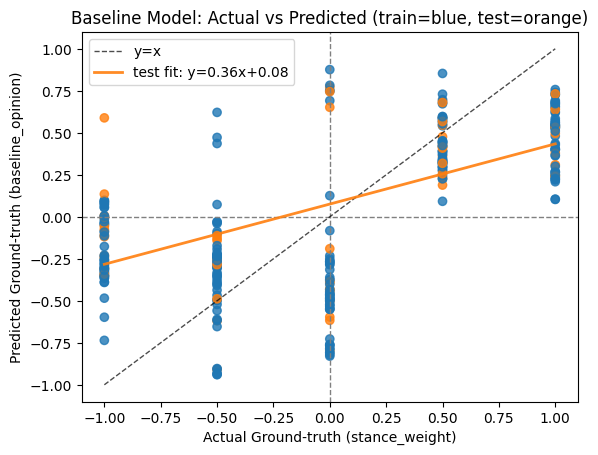

In [4]:
plt.figure()
if baseline_available and df_baseline is not None:
    colors = np.where(df_baseline["_is_test_baseline"], "tab:orange", "tab:blue")
    plt.scatter(df_baseline["stance_weight"], df_baseline["baseline_opinion"], alpha=0.8, c=colors)
    plt.xlabel("Actual Ground-truth (stance_weight)")
    plt.ylabel("Predicted Ground-truth (baseline_opinion)")
    plt.title("Baseline Model: Actual vs Predicted (train=blue, test=orange)")
    plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")

    # Reference line y=x (perfect prediction)
    xmin, xmax = float(df_baseline["stance_weight"].min()), float(df_baseline["stance_weight"].max())
    plt.plot([xmin, xmax], [xmin, xmax], linestyle="--", linewidth=1, color="black", alpha=0.7, label="y=x")

    # Best-fit line on test points (shows trend vs perfect y=x)
    test_df = df_baseline[df_baseline["_is_test_baseline"]]
    if len(test_df) >= 2:
        m, c = np.polyfit(test_df["stance_weight"].to_numpy(float), test_df["baseline_opinion"].to_numpy(float), deg=1)
        xs = np.array([xmin, xmax], dtype=float)
        plt.plot(xs, m * xs + c, linewidth=2, color="tab:orange", alpha=0.9, label=f"test fit: y={m:.2f}x+{c:.2f}")

    plt.legend()
else:
    print("Baseline unavailable; no baseline plot (stance_weight missing or all-NaN).")
plt.show()

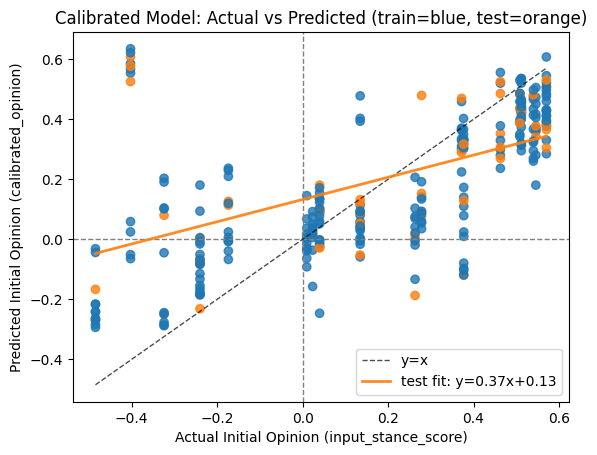

In [5]:
plt.figure()
colors = np.where(df["_is_test"], "tab:orange", "tab:blue")
plt.scatter(df["input_stance_score"], df["calibrated_opinion"], alpha=0.8, c=colors)
plt.xlabel("Actual Initial Opinion (input_stance_score)")
plt.ylabel("Predicted Initial Opinion (calibrated_opinion)")
plt.title("Calibrated Model: Actual vs Predicted (train=blue, test=orange)")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")

# Reference line y=x
xmin, xmax = float(df["input_stance_score"].min()), float(df["input_stance_score"].max())
plt.plot([xmin, xmax], [xmin, xmax], linestyle="--", linewidth=1, color="black", alpha=0.7, label="y=x")

# Best-fit line on test points (shows trend vs perfect y=x)
test_df = df[df["_is_test"]]
if len(test_df) >= 2:
    m, c = np.polyfit(test_df["input_stance_score"].to_numpy(float), test_df["calibrated_opinion"].to_numpy(float), deg=1)
    xs = np.array([xmin, xmax], dtype=float)
    plt.plot(xs, m * xs + c, linewidth=2, color="tab:orange", alpha=0.9, label=f"test fit: y={m:.2f}x+{c:.2f}")

plt.legend()
plt.show()

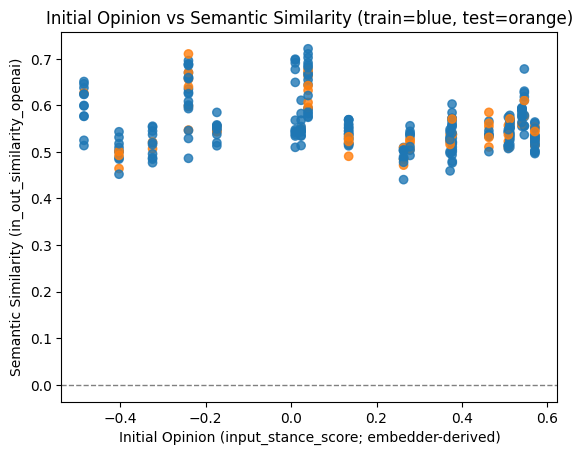

In [6]:
plt.figure()
colors = np.where(df["_is_test"], "tab:orange", "tab:blue")
plt.scatter(df["input_stance_score"], df[semantic_col], alpha=0.8, c=colors)
plt.xlabel("Initial Opinion (input_stance_score; embedder-derived)")
plt.ylabel(f"Semantic Similarity ({semantic_col})")
plt.title("Initial Opinion vs Semantic Similarity (train=blue, test=orange)")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

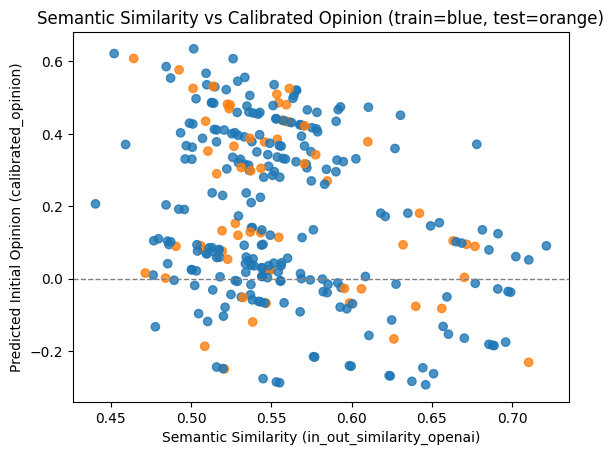

In [7]:
plt.figure()
colors = np.where(df["_is_test"], "tab:orange", "tab:blue")
plt.scatter(df[semantic_col], df["calibrated_opinion"], alpha=0.8, c=colors)
plt.xlabel(f"Semantic Similarity ({semantic_col})")
plt.ylabel("Predicted Initial Opinion (calibrated_opinion)")
plt.title("Semantic Similarity vs Calibrated Opinion (train=blue, test=orange)")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

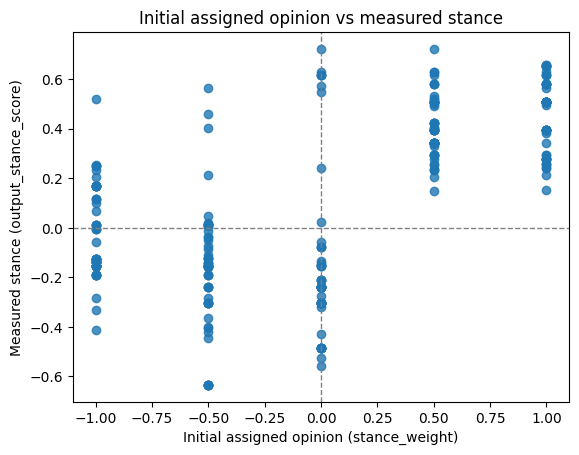

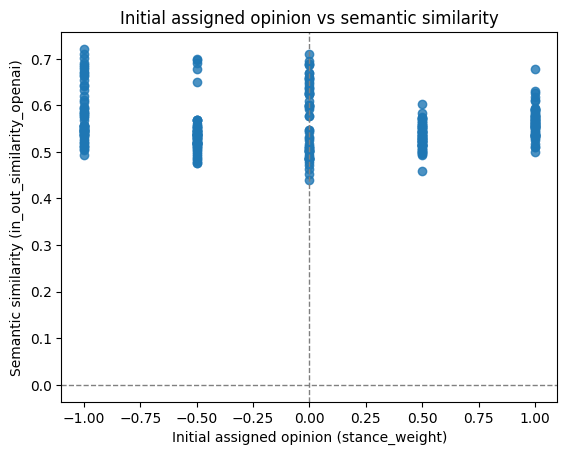

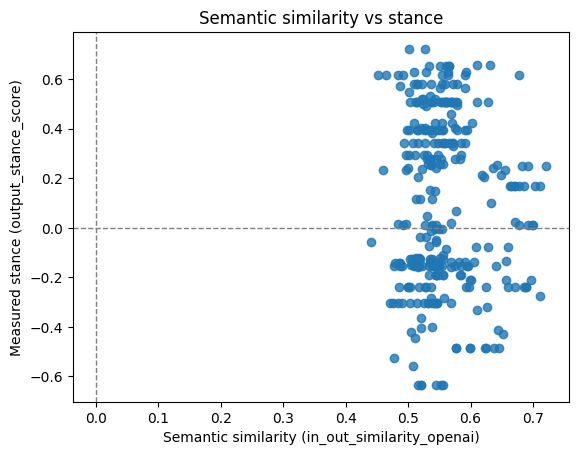

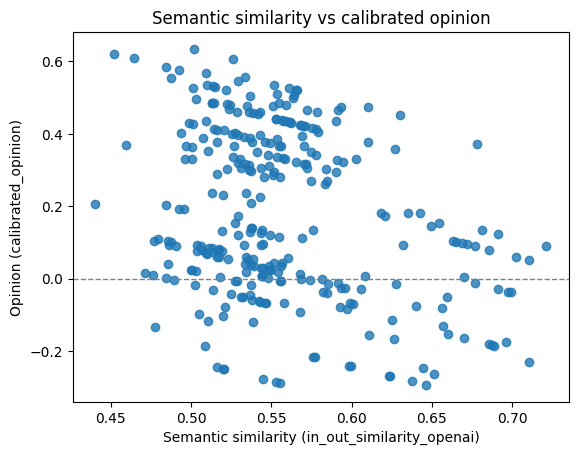

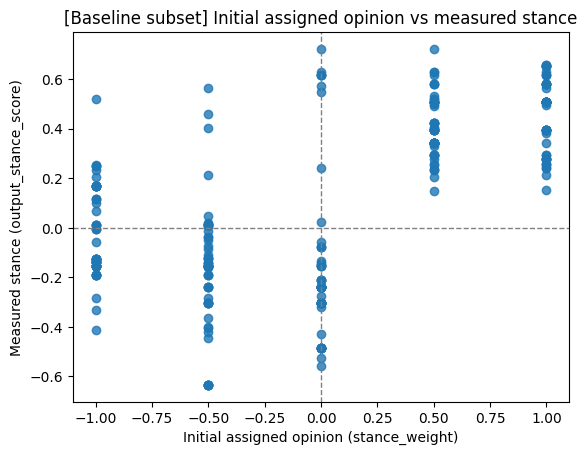

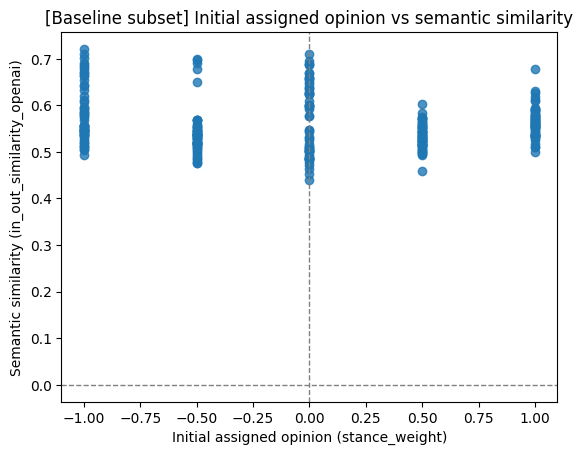

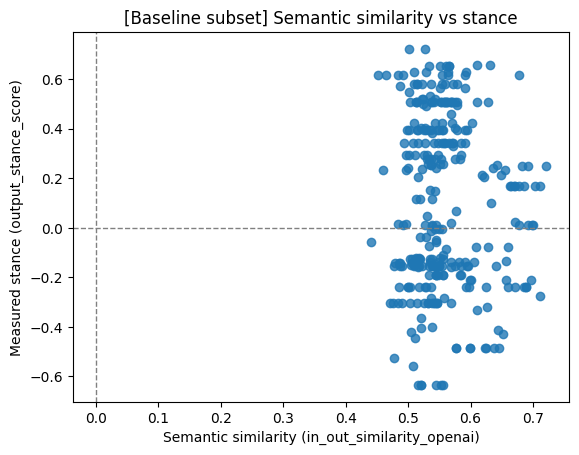

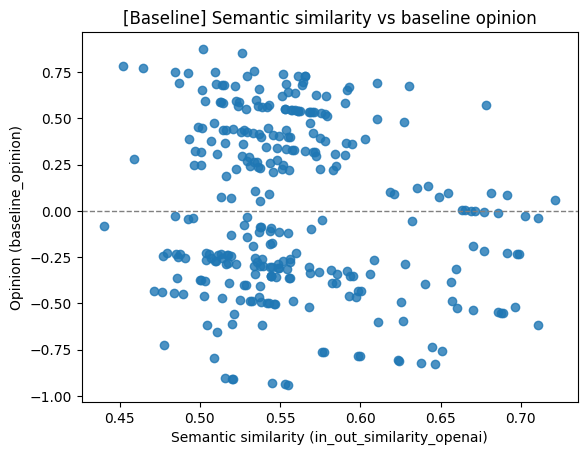

In [8]:
# --- Section 5-style diagnostics (requested) ---
def _first_available(colnames):
    for name in colnames:
        if name in df.columns and (not df[name].isna().all()):
            return name
    return None

assigned_col = _first_available(["stance_weight", "input_stance_score"])  # "assigned" = ground-truth if present, else embedder initial
measured_stance_col = _first_available(["output_stance_score"])
if assigned_col is None or measured_stance_col is None:
    raise KeyError("Need stance_weight or input_stance_score AND output_stance_score for diagnostics")

# 1) Initial assigned opinion vs measured stance
plt.figure()
plt.scatter(df[assigned_col], df[measured_stance_col], alpha=0.8)
plt.xlabel(f"Initial assigned opinion ({assigned_col})")
plt.ylabel(f"Measured stance ({measured_stance_col})")
plt.title("Initial assigned opinion vs measured stance")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

# 2) Initial assigned opinion vs semantic similarity
plt.figure()
plt.scatter(df[assigned_col], df[semantic_col], alpha=0.8)
plt.xlabel(f"Initial assigned opinion ({assigned_col})")
plt.ylabel(f"Semantic similarity ({semantic_col})")
plt.title("Initial assigned opinion vs semantic similarity")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

# 3) Semantic similarity vs stance
plt.figure()
plt.scatter(df[semantic_col], df[measured_stance_col], alpha=0.8)
plt.xlabel(f"Semantic similarity ({semantic_col})")
plt.ylabel(f"Measured stance ({measured_stance_col})")
plt.title("Semantic similarity vs stance")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

# Requested: use calibrated opinion score (opinion on vertical)
if "calibrated_opinion" in df.columns:
    plt.figure()
    plt.scatter(df[semantic_col], df["calibrated_opinion"], alpha=0.8)
    plt.xlabel(f"Semantic similarity ({semantic_col})")
    plt.ylabel("Opinion (calibrated_opinion)")
    plt.title("Semantic similarity vs calibrated opinion")
    plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.show()

# Baseline versions (only if stance_weight exists and baseline was fit)
if baseline_available and df_baseline is not None:
    # assigned = stance_weight, opinion = baseline_opinion
    plt.figure()
    plt.scatter(df_baseline["stance_weight"], df_baseline["output_stance_score"], alpha=0.8)
    plt.xlabel("Initial assigned opinion (stance_weight)")
    plt.ylabel("Measured stance (output_stance_score)")
    plt.title("[Baseline subset] Initial assigned opinion vs measured stance")
    plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.show()

    plt.figure()
    plt.scatter(df_baseline["stance_weight"], df_baseline[semantic_col], alpha=0.8)
    plt.xlabel("Initial assigned opinion (stance_weight)")
    plt.ylabel(f"Semantic similarity ({semantic_col})")
    plt.title("[Baseline subset] Initial assigned opinion vs semantic similarity")
    plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.show()

    plt.figure()
    plt.scatter(df_baseline[semantic_col], df_baseline["output_stance_score"], alpha=0.8)
    plt.xlabel(f"Semantic similarity ({semantic_col})")
    plt.ylabel("Measured stance (output_stance_score)")
    plt.title("[Baseline subset] Semantic similarity vs stance")
    plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.show()

    plt.figure()
    plt.scatter(df_baseline[semantic_col], df_baseline["baseline_opinion"], alpha=0.8)
    plt.xlabel(f"Semantic similarity ({semantic_col})")
    plt.ylabel("Opinion (baseline_opinion)")
    plt.title("[Baseline] Semantic similarity vs baseline opinion")
    plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
    plt.show()